In [1]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!python -m wget $data -o data-6.csv


Saved under data-6.csv


In [5]:
df = pd.read_csv("data-6.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [7]:
df = df.reset_index(drop=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [9]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

In [11]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [12]:
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [20]:
from sklearn.feature_extraction import DictVectorizer

In [21]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [26]:
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [28]:
print(export_text(tree, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [36]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

res = rf.predict(X_val)
score = mean_squared_error(res, y_val, squared=False)
score

0.24527740463893766

In [39]:
from tqdm.auto import tqdm

In [42]:
scores = []
estimators = range(10, 201, 10)

for e in tqdm(estimators):
    rf = RandomForestRegressor(n_estimators=e, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((e, score))

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
columns = ['n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,n_estimators,score
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235021


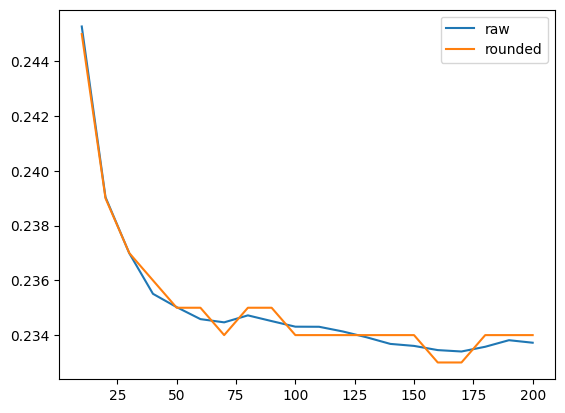

In [47]:
plt.plot(df_scores.n_estimators, df_scores.score, label='raw')
plt.plot(df_scores.n_estimators, df_scores.score.round(3), label='rounded')
plt.legend()

In [48]:
scores = []
max_depth = [10, 15, 20, 25]

for d in tqdm(max_depth):
    rf = RandomForestRegressor(n_estimators=0, max_depth=d, random_state=1, n_jobs=-1, warm_start=True)
    
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))


columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

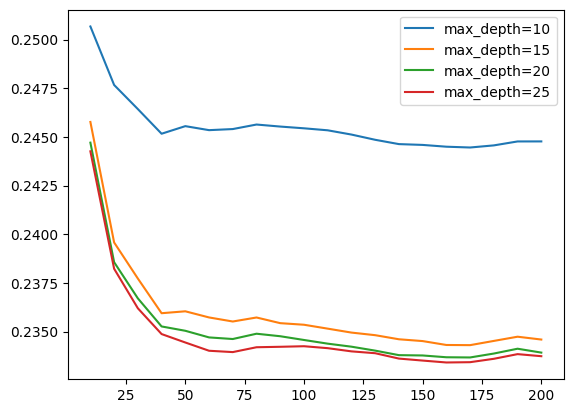

In [49]:
for d in max_depth:
    df_subset = df_scores[df_scores['max_depth'] == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')

plt.legend()

In [53]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_train, y_train)

df_importances = pd.DataFrame()
df_importances['feature_name'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_

df_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


In [54]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/99.8 MB 7.6 MB/s eta 0:00:14
   ---------------------------------------- 0.8/99.8 MB 8.2 MB/s eta 0:00:13
   ---------------------------------------- 1.2/99.8 MB 8.4 MB/s eta 0:00:12
    --------------------------------------- 1.7/99.8 MB 8.9 MB/s eta 0:00:12
    --------------------------------------- 2.2/99.8 MB 9.2 MB/s eta 0:00:11
   - -------------------------------------- 2.6/99.8 MB 9.7 MB/s eta 0:00:11
   - -------------------------------------- 3.1/99.8 MB 9.4 MB/s eta 0:00:11
   - -------------------------------------- 3.5/99.8 MB 9.4 MB/s eta 0:00:11
   - -------------------------------------- 4.0/99.8 MB 9.4 MB/s eta 0:00:11
   - -------------------------------------- 4.4/99.8 MB 9.4 MB/s eta 0:00:11
   - -------------------------------------- 4.9/99.8 MB 9.7 MB/s eta 0:00:10
   -- ------------------------------------- 5.3/99.8 MB 9.7 MB/s eta 0:00:10
   -- 


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import xgboost as xgb

In [59]:
features = [f.replace('<', 'LESS ') for f in list(dv.get_feature_names_out())]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=LESS 1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [60]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [61]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [70]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        iteration_str, train_str, val_str = line.split('\t')
        iteration = int(iteration_str.strip('[]'))
        train = float(train_str.split(":")[1])
        val = float(val_str.split(":")[1])
        
        results.append((iteration, train, val))
    
    columns = ['iter', 'train', 'val']
    df_progress = pd.DataFrame(results, columns=columns)
    return df_progress

In [78]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, 
                  verbose_eval=5,
                  evals=watchlist)

In [79]:
scores['eta=%s' % xgb_params['eta']] = parse_xgb_output(output_03)

In [80]:
%%capture output_01

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, 
                  verbose_eval=5,
                  evals=watchlist)

In [81]:
scores['eta=%s' % xgb_params['eta']] = parse_xgb_output(output_01)

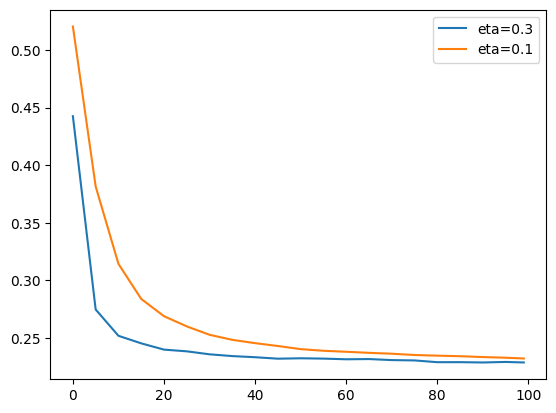

In [82]:
plt.plot(scores['eta=0.3'].iter, scores['eta=0.3'].val, label='eta=0.3')
plt.plot(scores['eta=0.1'].iter, scores['eta=0.1'].val, label='eta=0.1')
plt.legend()